## Workflow

Data Workflow (for one batch of images – steps 1 and 2 are at Mayo, remaining steps at UWL)

1. (At Mayo) Get Datamart file of studies to be downloaded
2. (At Mayo) Use Simon’s Dagster pipeline with Notion to 
    a. Download studies as dicom files
    b. Remove pixel level patient info
    c. Number images starting from previous batch
    d. Number patients starting from previous batch
    e. Save images in “images” folder
    f. Save all the images in “images” folder with the corresponding dicom headers in json file (really a list of dictionaries)
    g. Save all the videos (talk to Simon about this bit)
    h. Save key file in secure location
    i. Transfer batch and (total) key file to OneDrive
3. (At UWL – I have code for this) Parse the json file to produce a csv file with image_id, patient_id, biopsy, birds, size, weight, etc., ultrasound region rectangle, dx, dy, image_type (this will be expanded with recently added fields)
4. (At UWL and Mayo) Fix wrong or missing biopsy and birads results
    a. Look for biopsy and birads results that are inconclusive
    b. Match the anonymized ids to the original accession numbers (at Mayo) and ask Dr. Ellis to get corrections
5. Apply corrections to database csv for this batch
6. (At UWL – I have code for this) Run image processing and text extraction (mostly to get laterality and anatomy area)
7. (At UWL – I have code for this) Find nearest images for every image with calipers.  If the nearest image has distance <= 5, then include the twin for labeling, but not the image with calipers 
8. (At UWL) Determine the final set of images to send for labeling
    a. Exclude studies with mixed literalities
    b. Exclude all images that aren’t breast
    c. Exclude studies with unknown biopsy results (unless corrected)
    d. For each image with calipers, exclude it if has a twin which is included, otherwise keep it
    e. Add a label_cat field to help build tiles:  long, trans, doppler, other 
9. Save two versions of final database for this batch:  complete and with only images to send to labeling.  Store both with batch and append results to master database.
10. Build tiles and upload to Labelbox
11. Retrieve labels and masks from labelbox and add everything to master database.
    a. Keep track of rejected studies
    b. Track rejected images
    c. Track best images


In [24]:
import usImageProc as uip
import usTextProc as utp

import json
import pandas as pd
from PIL import Image
import cv2
import os
import re
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import largestinteriorrectangle as lir
from tqdm import tqdm
from time import sleep

import re

import easyocr
# configure easyocr reader
reader = easyocr.Reader(['en'])

In [25]:
# configuration
description_kw = ['breast','lt','long','rt','trans','area','palpated','axilla','areolar','radial','marked','supraclavicular','oblique','contrast']
description_kw_expand= ['cm','fn','breast','lt','long','rt','trans','area',
                        'palpated','axilla','areolar','radial','marked',
                        'supraclavicular','oblique','contrast','retroareolar',
                        'harmonics','axillary','subareolar','nipple','anti', 
                        'periareolar','subclavicular']
description_kw_contract = ['retro areolar', 
                           'sub areoloar', 
                           'peri areolar',
                           'anti -rad']
description_kw_sub = {'scm':'5 cm', 
                      'anti radial':'anti-rad', 
                      'axillary':'axilla', 
                      'axlla':'axilla',
                      'subclavcular':'subclavicular'}

description_labels_dict = {
    'area':{'breast':['breast'],
            'axilla':['axilla'],
            'supraclavicular':['superclavicular','supraclavicular'],
            'subclavicular':['subclavicular','subclavcular']},
    'laterality':{'left':['lt','left'],
                  'right':['rt','right']},
    'orientation':{'long':['long'],
                    'trans':['trans'],
                    'anti-radial':['anti-rad','anti-radial'],
                    'radial':['radial'],
                    'oblique':['oblique']}
}

# image id followed by dictionary of corrections to apply
corrections = { 4094:{'description':'long lt breast 10.00 scm fn area palpated', 'area':'breast'} }

In [26]:
# this is a list of all 73 images that contain sectors, use it to see we're correctly detecting all images with sectors

sectors = [2,11,12,94,100,287,291,522,523,525,526,
          527,528,530,531,533,536,544,559,635,637,
          638,639,640,641,645,646,892,916,917,918,
          919,920,972,973,978,983,984,1140,1146,1147,
          1150,1498,1553,1555,1556,1557,1710,1711,
           1712,1713,1714,1715,1716,1717,1718,1856,
          1857,1861,1862,1863,1864,1973,1978,1979,
          1982,1984,1985,1987,1988,1992,1995,1998]

## Workflow Step 3:

Convert dicom headers stored in database.json to database.csv


In [27]:
db_json_file = r'./database.json'

In [28]:
# helper function for assigning biopsy labels

benign_labels = ['Pathology Benign','Benign','Pathology Elevated Risk']
malignant_labels = ['Pathology Malignant','Malignant']

def biopsy_labeler(raw_label, b_labels = benign_labels, m_labels = malignant_labels):
    if raw_label in b_labels:
        label = 'benign'
    elif raw_label in m_labels:
        label = 'malignant'
    else:
        label = 'unknown'
    return label

In [29]:
# function to convert id to image filename
def image_id_to_filename( image_id ):
    return f'{image_id:06d}_cropped.png'    

In [30]:
def df_parser( db_json_file, missing_value = None ):
    
    # open, read, and close json file
    f = open(db_json_file)
    data = json.load(f)
    f.close()
    
    results_dict = {}
    for patient in data:
        patient_id = patient['anonymized_accession_num']
        biopsy = biopsy_labeler( patient['biopsy'] )
        birads = patient['birads']
        for image in patient['dicoms']:
            image_id = int(image['id'])
            filename = image_id_to_filename( image_id )
            metadata = image['metadata']
            patient_size = metadata.get('PatientSize',missing_value)
            patient_weight = metadata.get('PatientWeight',missing_value)
            us_region = metadata['SequenceOfUltrasoundRegions'][0]
            us_x0 = us_region['RegionLocationMinX0']
            us_y0 = us_region['RegionLocationMinY0']
            us_x1 = us_region['RegionLocationMaxX1']
            us_y1 = us_region['RegionLocationMaxY1']
            delta_x = us_region['PhysicalDeltaX']
            delta_y = us_region['PhysicalDeltaY']
            image_type = metadata['PhotometricInterpretation'] #MONCHROME2 or RGB
            row_dict = {'patient_id':patient_id,
                        'biopsy':biopsy,
                        'birads':birads,
                        'filename':filename,
                        'patient_size':patient_size,
                        'patient_weight':patient_weight,
                        'us_x0':us_x0,
                        'us_y0':us_y0,
                        'us_x1':us_x1,
                        'us_y1':us_y1,
                        'delta_x': delta_x,
                        'delta_y': delta_y,
                        'image_type':image_type}
            results_dict[image_id] = row_dict

    df = pd.DataFrame.from_dict(results_dict,orient='index')
    df.reset_index(inplace=True)
    df.rename(columns = {'index':'image_id'},inplace=True)
    df.sort_values(by = ['patient_id', 'image_id'],inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns=['index'],inplace=True)
    return df

In [31]:
df = df_parser(db_json_file)
df.to_csv('database.csv',index=False)

## Workflow Step 6:

Run image processing and text extraction (mostly to get laterality and anatomy area).  This part of the processing is slow, takes 30+ min for 4000 images.  

Starts with database.csv (which was the original database for the current batch extracted from the Mayo json file).  Will produce database_step6.csv which will include the crop region, other values extracted from the image, as well as parsed values from the text description.  Can be selectively applied by setting image_numbers to be an iterable containing the indices of the images to be processed.

In [32]:
image_folder_path = r"C:/Users/jbaggett/image"
proc_images_folder = r"C:/Users/jbaggett/proc_image"

input_file = r"database.csv"
output_file = r"database_step6.csv"

# processing configuration
debug = False
write_images = False # write out images with bounding boxes for debugging
display_images = False # used to display some images for debugging

# open database and get filenames to be processed
db_in = pd.read_csv(input_file)
files = db_in['filename']
num_files = len(files)
image_numbers = np.arange(num_files)

# open or create output database
import os.path
check_db_out = os.path.isfile(output_file)
if check_db_out:
    db_out = pd.read_csv(output_file)
else:
    db_out = db_in.copy()
    new_features = ['processed','crop_x', 'crop_y', 'crop_w', 'crop_h', 'description', 'size', 'sector_detected', 'darkness','area','laterality','orientation','clock_pos','nipple_dist']
    for nf in new_features:
        db_out[nf] = None
    db_out['processed'] = False
                

for i in tqdm(image_numbers):
    sleep(0.01) # not sure if this is really necessary
    if not db_out['processed'][i]:
        file_name = db_in['filename'][i]
        us_x = min(db_in['us_x0'][i],0)
        us_y = db_in['us_y0'][i]
        us_w = db_in['us_x1'][i]-us_x
        us_h = db_in['us_y1'][i]-us_y
        rect_us = (us_x, us_y, us_w, us_h)
        #print('rect_us: ', rect_us)
        # Check if the file is an image
        if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the full path to the image file

            if debug:
                print('Processing: ', file_name )

            full_filename = os.path.join(image_folder_path, file_name)
            image_out_path = os.path.join(proc_images_folder, file_name)

            # Open the image file and store it in an image object
            img = Image.open(full_filename)

            # recast image as numpy array
            img = np.array(img)
            img_orig = img.copy()

            img_dict = uip.img_processor(img, reader, 
                                         rect_US = rect_us,
                                         kw_list = description_kw)
            if debug: 
                print(img_dict)
                print('Processing Complete: ', file_name)

            # insert into total database
            new_features = ['crop_x', 'crop_y', 'crop_w', 'crop_h', 'description', 'size', 'is_sector', 'darkness']
            crop_x, crop_y, crop_w, crop_h = img_dict['rect_crop']
            description = img_dict['text_description']
            db_out.loc[i,'crop_x'] = crop_x
            db_out.loc[i,'crop_y'] = crop_y
            db_out.loc[i,'crop_w'] = crop_w
            db_out.loc[i,'crop_h'] = crop_h
            db_out.loc[i,'description'] = description
            db_out.loc[i,'size'] = img_dict['text_size']
            db_out.loc[i,'sector_detected'] = img_dict['sector_detected']
            db_out.loc[i,'darkness'] = img_dict['darkness']
            if len(description)>0:
                feature_dict = utp.extract_descript_features( description, description_labels_dict )
                display_str = ''
                for feature in feature_dict.keys():
                    db_out.loc[i,feature] = feature_dict[feature]
                    display_str = display_str + feature_dict[feature] + ' '
            else:
                display_str = ''

            if write_images or display_images: # add description and crop region to image
                img_orig = uip.add_rect(img_orig, img_dict['rect_crop'])
                img_orig = uip.add_text(img_orig, display_str)

            if write_images:
                cv2.imwrite(image_out_path,img_orig)
            if display_images:
                img2 = img_orig.copy()
                img2 = uip.add_rect(img2, img_dict['rect_machine'])
                img2 = uip.add_rect(img2, img_dict['rect_description'])
                img2 = uip.add_rect(img2, img_dict['rect_colorbar'])
                if len(img_dict['rect_sizebox'])>0:
                    img2 = uip.add_rect(img2, img_dict['rect_sizebox'])
                    
                fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 15)) 

                ax1.imshow(img_orig,cmap='gray')   
                ax2.imshow(img2,cmap='gray')
                fig.show()                
                
db_out.to_csv(output_file,index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 4098/4098 [27:30<00:00,  2.48it/s]


## Workflow Step 7

Starting from the database csv produced in Step 6 find the nearest image pixel-wise for each image within each study.

Input: 'database_step6.csv'
Output: 'database_step7.csv'

In [33]:
# database utilities

def fetch_index_for_patient_id( id, db ):
    # id is a patient id number that should be listed in database
    # returns list of indices in dataframe for the given id
    
    if id in db['patient_id'].tolist():
         indices= db.index[db['patient_id']==id].tolist()
    else:
        indices = []
    return indices


In [34]:
image_folder_path = r"C:/Users/jbaggett/image"

input_file = r'database_step6.csv'
output_file = r'database_step7.csv'

db_in = pd.read_csv(input_file)
patient_ids = db_in['patient_id'].unique()
        
db_out = db_in.copy()
db_out['closest_fn']=''
db_out['distance'] = -1

for pid in tqdm(patient_ids):
    result = uip.find_nearest_images(db_in, pid, image_folder_path)
    idxs = result.keys()
    for i in idxs:
        db_out.loc[i,'closest_fn'] = result[i]['sister_filename']
        db_out.loc[i,'distance'] = result[i]['distance']
        
db_out.to_csv(output_file,index=False)


100%|████████████████████████████████████████████████████████████████████████████████| 361/361 [09:06<00:00,  1.51s/it]


## Workflow Step 8 - Identify Images to be Labeled

* Add a boolean column 'label'
* set label = False if mixed lateralities
* set label = False if not area == 'breast'
* add a boolean column 'has_calipers'
* for each image with calipers
    * if it has twin (dist < 5) then set label = True for twin and label = False for the image with calipers
    * an image with calipers can stay in if it doesn't have a twin

In [35]:

def find_mixed_lateralities( db ):
    ''' returns a list of all patient ids for which the study contains both left and right lateralities (to be deleted for now)
    
    Args:
        db is a dataframe with one row per image, must have columns for patient_id and laterality
        
    Returns:
        list of patient ids from db for which the lateralities are mixed
    '''
    db['latIsLeft']=(db['laterality']=='left')
    df = db.groupby(['patient_id']).agg({'patient_id':'count', 'latIsLeft':'sum'})
    df['notPure'] = ~( (df['latIsLeft']==0) |  (df['latIsLeft']==df['patient_id']) )
    
    db = db.drop(columns=['latIsLeft'])
    
    mixedPatientIDs = df[df['notPure']].index.tolist()
    return mixedPatientIDs

def choose_images_to_label(db):
    
    db['label']=True

    # find all of the rows with calipers
    db['has_calipers'] = ~np.isnan(db['size'].str.len())
    caliper_indices = np.where( db['has_calipers'])[0]

    # loop over caliper rows and tag twin images (not efficient)
    for idx in caliper_indices:
        distance = db.loc[idx,'distance']
        if distance <= 5:
            twin_filename = db.loc[idx,'closest_fn']
            twin_idx = np.where( db['filename'] == twin_filename )[0][0]
            db.loc[twin_idx,'label'] = True # redundant
            db.loc[idx,'label'] = False
            
    # set label = False for all non-breast images
    db.loc[db['area']!='breast','label'] = False
    
    mixedIDs = find_mixed_lateralities( db )
    db.loc[np.isin(db['patient_id'],mixedIDs),'label']=False
    
    return db

def add_labeling_categories(db):
    db['label_cat'] = ''
    num_rows = db.shape[0]
    for i in range(num_rows):
        if db.loc[i,'label']:
            orient = db.loc[i,'orientation']
            image_type = db.loc[i,'image_type']
            if image_type=='RGB':
                label_cat = 'doppler'
            elif orient in ['trans','long']:
                label_cat = orient
            else:
                label_cat = 'other'
            db.loc[i,'label_cat'] = label_cat
    return db


db = pd.read_csv('database_step7.csv')
db = choose_images_to_label(db)
db = add_labeling_categories(db)

db.to_csv('database_step8.csv',index=False)


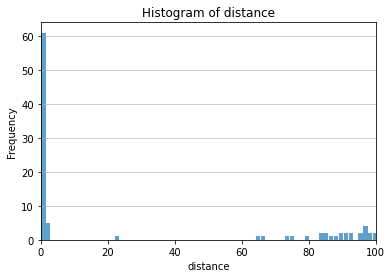

In [12]:
# ignore - can be used to visualize distribution of quantitative data in a column

def plot_histogram_with_limits(dataframe, column_name, xmin=None, xmax=None):
    column_data = dataframe[column_name]

    plt.hist(column_data, bins=100, alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    
    if xmin is not None and xmax is not None:
        plt.xlim(xmin, xmax)
    
    plt.show()


plot_histogram_with_limits(db_out,'distance',xmin=0,xmax=100)
